In [1]:
# Libraries import
from datetime import datetime
from plotly.offline import init_notebook_mode
from googletrans import Translator

import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sn

import requests
import json

In [2]:
# Data import - 'Datos abiertos COVID-19 (Colombia)'
data = pd.DataFrame.from_dict(requests.get('https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=9999999999999').json())
#data

In [3]:
# Data import - 'World Health Organization (WHO) COVID-19 Global Data'
who_data = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')
#who_data

In [4]:
# Data import - 'Colombia GeoJson'
geojson = requests.get('https://gist.githubusercontent.com/john-guerra/43c7656821069d00dcbc/raw/be6a6e239cd5b5b803c6e7c2ec405b793a9064dd/Colombia.geo.json').json()
#geojson

In [5]:
# Data cleaning and adjusting
translator = Translator()
translations = {}

departments = {}
status_counts = []

data.columns = ['Id de caso', 'Fecha de notificación', 'Código DIVIPOLA', 'Ciudad de ubicación', 'Departamento', 'Estado', 'Edad', 'Sexo', 'Tipo', 'Severidad','País de procedencia', 'Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web', 'Tipo de recuperación', 'Código departamento', 'Código país', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Fecha de defunción']
#who_data.columns = ['']

for element in data['País de procedencia'].unique():
    translations[element] = translator.translate(" ".join(element.split(" ")[:2])).text if type(element) !=  float else 'Colombia'

data['País de procedencia'].replace(translations, inplace=True)

for column in ['Edad', 'Código departamento']:
    data[column] = data[column].apply(lambda x: int(x))
    
data['Clasificación de edad'] = pd.cut(x=data['Edad'], bins=[0,10,20,30,40,50,60,70,80,90,np.inf], include_lowest=True, labels=['0 - 10', '10 - 20', '20 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 100+'])

for column in ['Ciudad de ubicación', 'Estado', 'Sexo', 'Tipo', 'Severidad', 'País de procedencia']:
    data[column] = data[column].str.capitalize()
    
for column in ['Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de defunción', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web']:
    data[column] = data[column].str.slice(0,10).replace(r'(\d+)-(\d+)-(\d+)', r'\1-\2-\3', regex=True).apply(lambda x: pd.to_datetime(x, dayfirst=True, errors='ignore'))

for element in geojson['features']:
    departments[int(element['properties']['DPTO'])] = element['properties']['NOMBRE_DPT']
    
status_counts = data['Estado'].value_counts().to_list()
    
data = data[['Id de caso', 'Fecha de reporte web', 'Fecha de diagnóstico', 'Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de recuperación', 'Fecha de defunción', 'Ciudad de ubicación', 'Departamento', 'Severidad', 'Estado', 'Edad', 'Clasificación de edad', 'Sexo', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Tipo', 'Tipo de recuperación', 'País de procedencia', 'Código departamento', 'Código país', 'Código DIVIPOLA']]
data = data.set_index('Id de caso')

In [6]:
# Data storage
date = data['Fecha de reporte web'].iloc[-1].strftime('%Y-%m-%d')
data.to_csv(f'./Datasets/COVID-19 Status (Colombia) [{date}].csv', index = True)

In [7]:
# Helper functions
def GetBars(df):
    d = df.to_dict('list')
    #for i in range(df[]):

def numbers(div): #x
    for i in range(0, len(ax.patches)//div, 1):
        height = 0
        for j in range(0, div, 1):
            height += ax.patches[j*(len(ax.patches)//div)+i].get_height()
        ax.text(ax.patches[i].get_x()+(ax.patches[i].get_width()/10),height+(height/100)+10, int(height), fontsize=7, color='dimgrey', rotation=90)

def numbers_H(div): #y
    for i in range(0, len(ax.patches)//div, 1):
        width = 0
        for j in range(0, div, 1):
            width += ax.patches[j*(len(ax.patches)//div)+i].get_width()
        ax.text(width+(width/100)+10,ax.patches[i].get_y()+(ax.patches[i].get_height()/10), int(width), fontsize=7, color='dimgrey', rotation=0)

In [8]:
# Testing
#bars = GetBars()

bar_chart = go.Figure(
    data = go.Histogram(
        
    ),
    layout = go.Layout(
        title="Casos confirmados VS Clasificación de Edad (Estado)",
        yaxis_title="Clasificación de edad",
        xaxis_title="Casos confirmados",
    )
)
#bar_chart.show()

#data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).to_dict('list')

In [9]:
# In-line plots libraries import
%matplotlib inline
init_notebook_mode(connected = True)

# COVID-19 Status (Colombia) 🇨🇴

#### Fuente: <a href='https://datos.gov.co'>Datos Abiertos - Colombia</a>

### - Panorama nacional COVID-19 (Colombia)

In [10]:
local_map = go.Figure(go.Choropleth(
    z=data['Código departamento'].value_counts().sort_index().tolist(),
    locations=[departments[key] for key in sorted(departments.keys())],
    featureidkey='properties.NOMBRE_DPT',
    geojson=geojson,
    colorscale='blues',
    colorbar_title="Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

local_map.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds='locations')

local_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

local_map.show()

### - Casos activos VS Departamento (Estado)

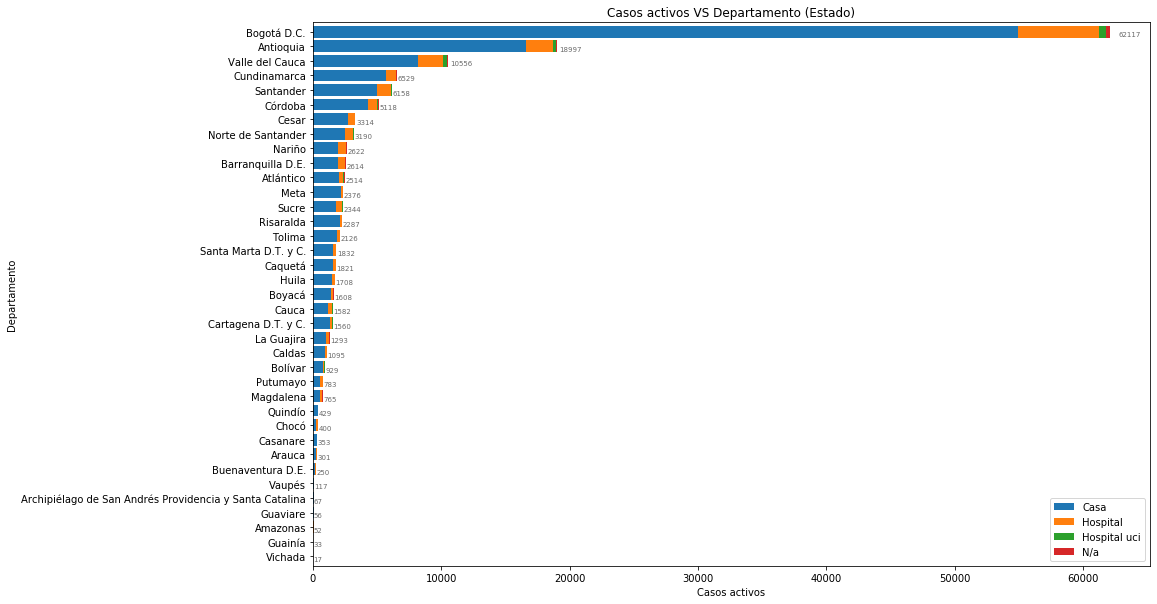

In [11]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos activos VS Departamento (Estado)'))
ax.set_xlabel('Casos activos')
ax.set_facecolor('w')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [12]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Hospital  \
Departamento                                                            
Bogotá D.C.                                         54919.0    6305.0   
Antioquia                                           16564.0    2148.0   
Valle del Cauca                                      8215.0    1949.0   
Cundinamarca                                         5711.0     763.0   
Santander                                            5027.0    1049.0   
Córdoba                                              4305.0     654.0   
Cesar                                                2701.0     552.0   
Norte de Santander                                   2493.0     602.0   
Nariño                                               1948.0     601.0   
Barranquilla D.E.                                    1968.0     499.0   
Atlántico                                            2000.0     364.0   
Meta                                                 2158.0     191.0   
Sucre                                                1821.0     477.0   
Risaralda                                            2105.0     164.0   
Tolima                                               1849.0     231.0   
Santa Marta D.T. y C.                                1552.0     252.0   
Caquetá                                              1551.0     247.0   
Huila                                                1457.0     233.0   
Boyacá                                               1437.0     145.0   
Cauca                                                1181.0     334.0   
Cartagena D.T. y C.                                  1293.0     194.0   
La Guajira                                           1035.0     223.0   
Caldas                                                968.0     104.0   
Bolívar                                               759.0     127.0   
Putumayo                                              586.0     184.0   
Magdalena                                             518.0     187.0   
Quindío                                               398.0      28.0   
Chocó                                                 226.0     144.0   
Casanare                                              306.0      43.0   
Arauca                                                270.0      27.0   
Buenaventura D.E.                                     127.0      99.0   
Vaupés                                                113.0       4.0   
Archipiélago de San Andrés Providencia y Santa ...     60.0       6.0   
Guaviare                                               51.0       4.0   
Amazonas                                               40.0       7.0   
Guainía                                                33.0       0.0   
Vichada                                                15.0       2.0   

Estado                                              Hospital uci    N/a  \
Departamento                                                              
Bogotá D.C.                                                603.0  290.0   
Antioquia                                                  198.0   87.0   
Valle del Cauca                                            292.0  100.0   
Cundinamarca                                                27.0   28.0   
Santander                                                   60.0   22.0   
Córdoba                                                     84.0   75.0   
Cesar                                                       48.0   13.0   
Norte de Santander                                          80.0   15.0   
Nariño                                                      46.0   27.0   
Barranquilla D.E.                                           51.0   96.0   
Atlántico                                                   63.0   87.0   
Meta                                                        12.0   15.0   
Sucre                                                       25.0   21.0   
Risaralda                  

### - Recuperados VS Departamento

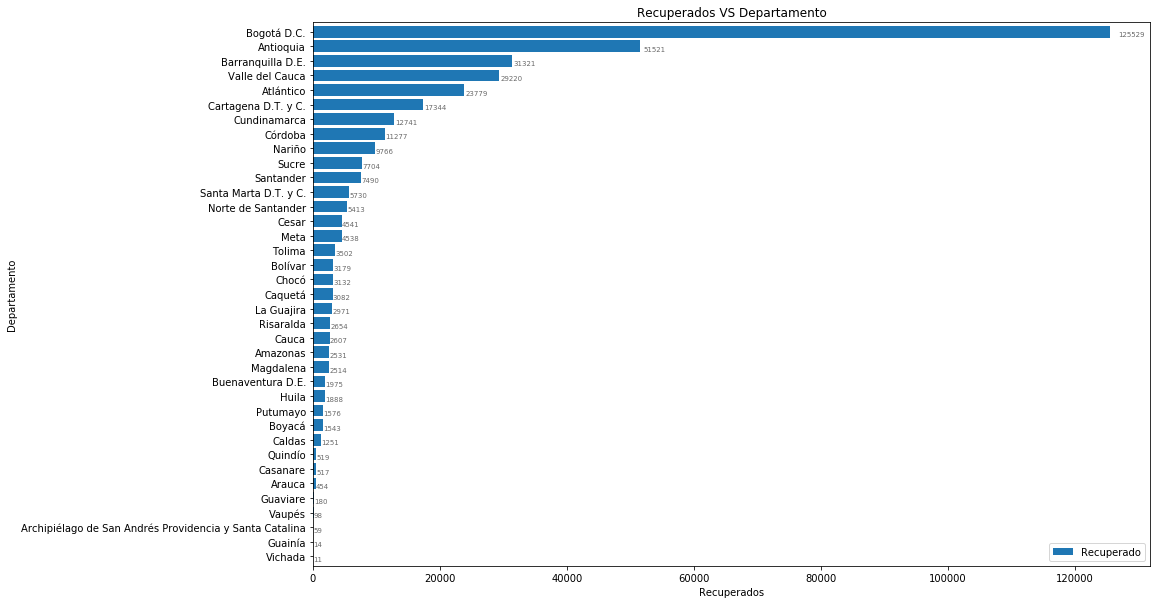

In [13]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [False, False, False, False, False, True]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Recuperados VS Departamento'))
ax.set_xlabel('Recuperados')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [14]:
li.sort_values('Total', ascending=False)

Estado                                              Recuperado     Total
Departamento                                                            
Bogotá D.C.                                           125529.0  125529.0
Antioquia                                              51521.0   51521.0
Barranquilla D.E.                                      31321.0   31321.0
Valle del Cauca                                        29220.0   29220.0
Atlántico                                              23779.0   23779.0
Cartagena D.T. y C.                                    17344.0   17344.0
Cundinamarca                                           12741.0   12741.0
Córdoba                                                11277.0   11277.0
Nariño                                                  9766.0    9766.0
Sucre                                                   7704.0    7704.0
Santander                                               7490.0    7490.0
Santa Marta D.T. y C.                                   5730.0    5730.0
Norte de Santander                                      5413.0    5413.0
Cesar                                                   4541.0    4541.0
Meta                                                    4538.0    4538.0
Tolima                                                  3502.0    3502.0
Bolívar                                                 3179.0    3179.0
Chocó                                                   3132.0    3132.0
Caquetá                                                 3082.0    3082.0
La Guajira                                              2971.0    2971.0
Risaralda                                               2654.0    2654.0
Cauca                                                   2607.0    2607.0
Amazonas                                                2531.0    2531.0
Magdalena                                               2514.0    2514.0
Buenaventura D.E.                                       1975.0    1975.0
Huila                                                   1888.0    1888.0
Putumayo                                                1576.0    1576.0
Boyacá                                                  1543.0    1543.0
Caldas                                                  1251.0    1251.0
Quindío                                                  519.0     519.0
Casanare                                                 517.0     517.0
Arauca                                                   454.0     454.0
Guaviare                                                 180.0     180.0
Vaupés                                                    98.0      98.0
Archipiélago de San Andrés Providencia y Santa ...        59.0      59.0
Guainía                                                   14.0      14.0
Vichada                                                   11.0      11.0

### - Fallecidos VS Departamento

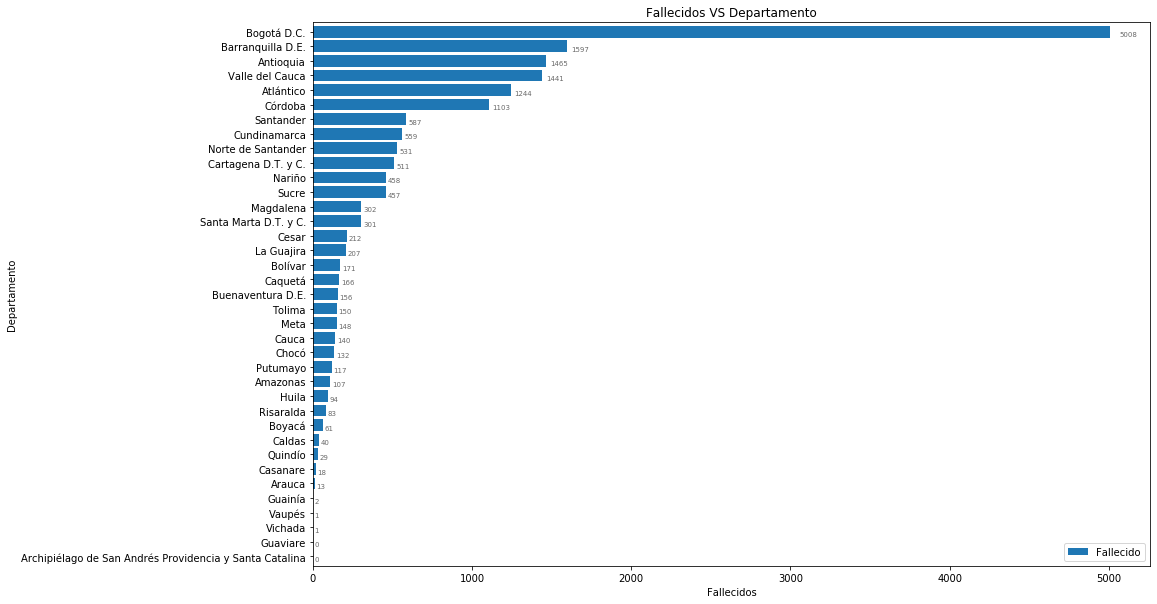

In [15]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [False, True, False, False, False, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Fallecidos VS Departamento'))
ax.set_xlabel('Fallecidos')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [16]:
li.sort_values('Total', ascending=False)

Estado                                              Fallecido   Total
Departamento                                                         
Bogotá D.C.                                            5008.0  5008.0
Barranquilla D.E.                                      1597.0  1597.0
Antioquia                                              1465.0  1465.0
Valle del Cauca                                        1441.0  1441.0
Atlántico                                              1244.0  1244.0
Córdoba                                                1103.0  1103.0
Santander                                               587.0   587.0
Cundinamarca                                            559.0   559.0
Norte de Santander                                      531.0   531.0
Cartagena D.T. y C.                                     511.0   511.0
Nariño                                                  458.0   458.0
Sucre                                                   457.0   457.0
Magdalena                                               302.0   302.0
Santa Marta D.T. y C.                                   301.0   301.0
Cesar                                                   212.0   212.0
La Guajira                                              207.0   207.0
Bolívar                                                 171.0   171.0
Caquetá                                                 166.0   166.0
Buenaventura D.E.                                       156.0   156.0
Tolima                                                  150.0   150.0
Meta                                                    148.0   148.0
Cauca                                                   140.0   140.0
Chocó                                                   132.0   132.0
Putumayo                                                117.0   117.0
Amazonas                                                107.0   107.0
Huila                                                    94.0    94.0
Risaralda                                                83.0    83.0
Boyacá                                                   61.0    61.0
Caldas                                                   40.0    40.0
Quindío                                                  29.0    29.0
Casanare                                                 18.0    18.0
Arauca                                                   13.0    13.0
Guainía                                                   2.0     2.0
Vaupés                                                    1.0     1.0
Vichada                                                   1.0     1.0
Guaviare                                                  0.0     0.0
Archipiélago de San Andrés Providencia y Santa ...        0.0     0.0

* Fallecimientos relacionados al COVID-19.

### - Casos confirmados VS Departamento (Estado)

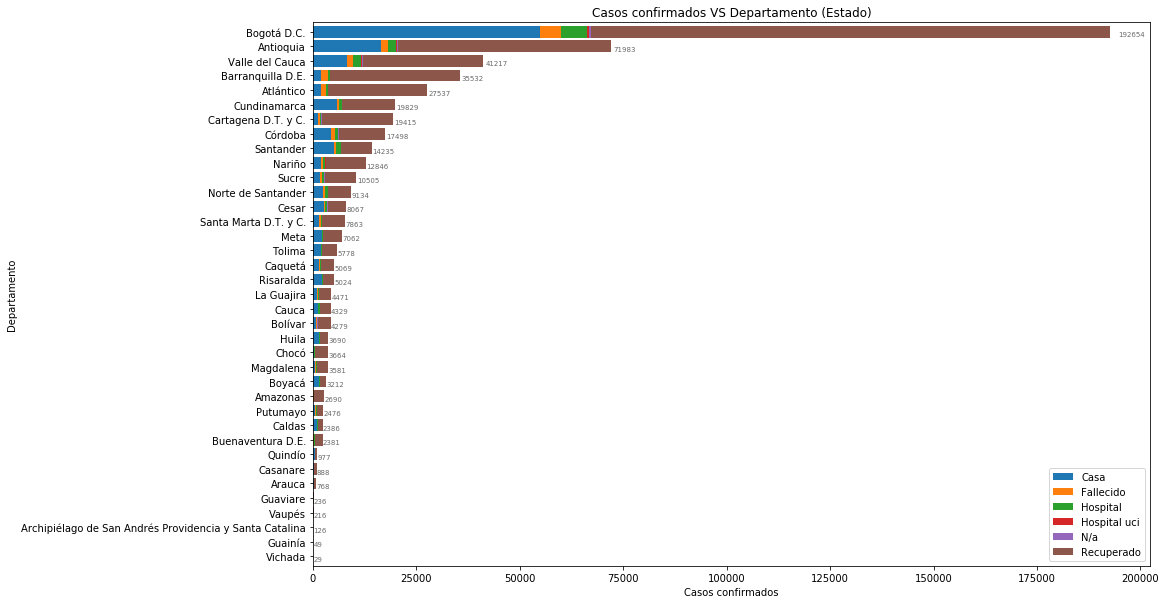

In [17]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Departamento (Estado)'))
ax.set_xlabel('Casos confirmados')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [18]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Fallecido  \
Departamento                                                             
Bogotá D.C.                                         54919.0     5008.0   
Antioquia                                           16564.0     1465.0   
Valle del Cauca                                      8215.0     1441.0   
Barranquilla D.E.                                    1968.0     1597.0   
Atlántico                                            2000.0     1244.0   
Cundinamarca                                         5711.0      559.0   
Cartagena D.T. y C.                                  1293.0      511.0   
Córdoba                                              4305.0     1103.0   
Santander                                            5027.0      587.0   
Nariño                                               1948.0      458.0   
Sucre                                                1821.0      457.0   
Norte de Santander                                   2493.0      531.0   
Cesar                                                2701.0      212.0   
Santa Marta D.T. y C.                                1552.0      301.0   
Meta                                                 2158.0      148.0   
Tolima                                               1849.0      150.0   
Caquetá                                              1551.0      166.0   
Risaralda                                            2105.0       83.0   
La Guajira                                           1035.0      207.0   
Cauca                                                1181.0      140.0   
Bolívar                                               759.0      171.0   
Huila                                                1457.0       94.0   
Chocó                                                 226.0      132.0   
Magdalena                                             518.0      302.0   
Boyacá                                               1437.0       61.0   
Amazonas                                               40.0      107.0   
Putumayo                                              586.0      117.0   
Caldas                                                968.0       40.0   
Buenaventura D.E.                                     127.0      156.0   
Quindío                                               398.0       29.0   
Casanare                                              306.0       18.0   
Arauca                                                270.0       13.0   
Guaviare                                               51.0        0.0   
Vaupés                                                113.0        1.0   
Archipiélago de San Andrés Providencia y Santa ...     60.0        0.0   
Guainía                                                33.0        2.0   
Vichada                                                15.0        1.0   

Estado                                              Hospital  Hospital uci  \
Departamento                                                                 
Bogotá D.C.                                           6305.0         603.0   
Antioquia                                             2148.0         198.0   
Valle del Cauca                                       1949.0         292.0   
Barranquilla D.E.                                      499.0          51.0   
Atlántico                                              364.0          63.0   
Cundinamarca                                           763.0          27.0   
Cartagena D.T. y C.                                    194.0          41.0   
Córdoba                                                654.0          84.0   
Santander                                             1049.0          60.0   
Nariño                                                 601.0          46.0   
Sucre                                                  477.0          25.0   
Norte de Santander                                     602.0          80.0   
Cesar                

### - Casos confirmados VS Departamento (Sexo)

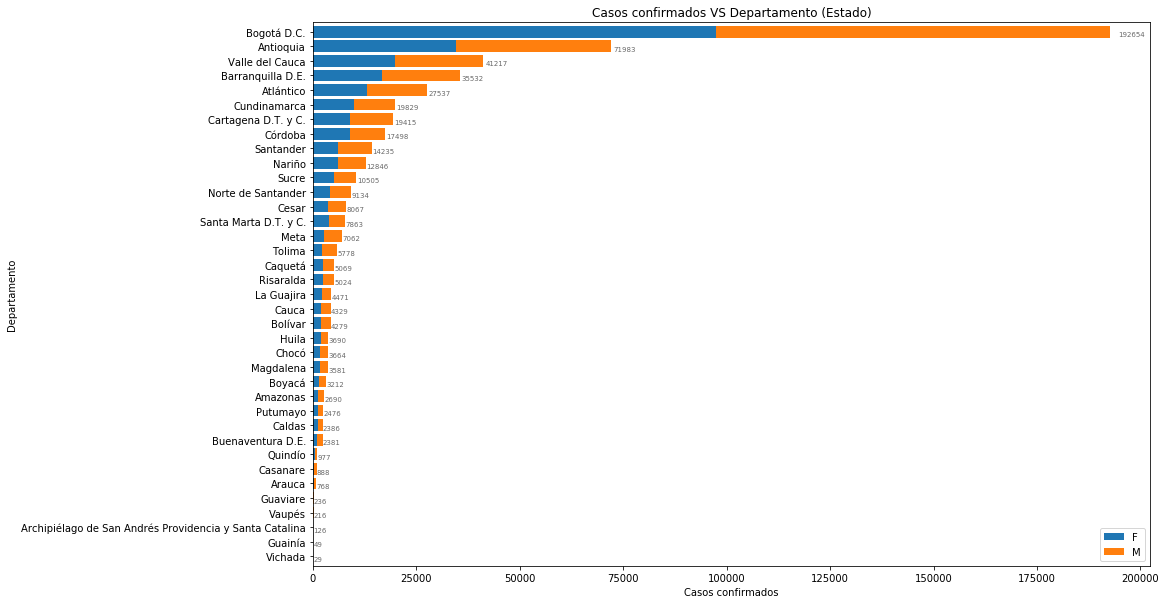

In [19]:
li = data.groupby(['Departamento', 'Sexo']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Departamento (Estado)'))
ax.set_xlabel('Casos confirmados')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [20]:
li.sort_values('Total', ascending=False)

Sexo                                                    F      M   Total
Departamento                                                            
Bogotá D.C.                                         97379  95275  192654
Antioquia                                           34492  37491   71983
Valle del Cauca                                     19922  21295   41217
Barranquilla D.E.                                   16712  18820   35532
Atlántico                                           13047  14490   27537
Cundinamarca                                        10032   9797   19829
Cartagena D.T. y C.                                  8912  10503   19415
Córdoba                                              9023   8475   17498
Santander                                            6121   8114   14235
Nariño                                               6154   6692   12846
Sucre                                                5046   5459   10505
Norte de Santander                                   4130   5004    9134
Cesar                                                3703   4364    8067
Santa Marta D.T. y C.                                3966   3897    7863
Meta                                                 2592   4470    7062
Tolima                                               2253   3525    5778
Caquetá                                              2511   2558    5069
Risaralda                                            2463   2561    5024
La Guajira                                           2256   2215    4471
Cauca                                                2017   2312    4329
Bolívar                                              1969   2310    4279
Huila                                                1832   1858    3690
Chocó                                                1734   1930    3664
Magdalena                                            1809   1772    3581
Boyacá                                               1499   1713    3212
Amazonas                                             1164   1526    2690
Putumayo                                             1120   1356    2476
Caldas                                               1129   1257    2386
Buenaventura D.E.                                     890   1491    2381
Quindío                                               485    492     977
Casanare                                              371    517     888
Arauca                                                236    532     768
Guaviare                                               35    201     236
Vaupés                                                 97    119     216
Archipiélago de San Andrés Providencia y Santa ...     70     56     126
Guainía                                                17     32      49
Vichada                                                 5     24      29

### - Dataset COVID-19 (Colombia)

In [21]:
data

Fecha de reporte web Fecha de diagnóstico Fecha de notificación  \
Id de caso                                                                   
1                    2020-03-06           2020-03-06            2020-03-02   
2                    2020-03-09           2020-03-09            2020-03-06   
3                    2020-03-09           2020-03-09            2020-03-07   
4                    2020-03-11           2020-03-11            2020-03-09   
5                    2020-03-11           2020-03-11            2020-03-09   
...                         ...                  ...                   ...   
551732               2020-08-24           2020-08-22            2020-08-11   
551733               2020-08-24           2020-08-22            2020-08-11   
551734               2020-08-24           2020-08-22            2020-08-11   
551735               2020-08-24           2020-08-20            2020-08-09   
551736               2020-08-24           2020-08-06            2020-07-26   

           Fecha de inicio de síntomas Fecha de recuperación  \
Id de caso                                                     
1                  2020-02-27 00:00:00            2020-03-13   
2                  2020-03-04 00:00:00            2020-03-19   
3                  2020-02-29 00:00:00            2020-03-15   
4                  2020-03-06 00:00:00            2020-03-26   
5                  2020-03-08 00:00:00            2020-03-23   
...                                ...                   ...   
551732             2020-08-07 00:00:00                   NaT   
551733             2020-08-07 00:00:00                   NaT   
551734             2020-08-07 00:00:00                   NaT   
551735             2020-08-05 00:00:00                   NaT   
551736             2020-07-22 00:00:00                   NaT   

           Fecha de defunción  Ciudad de ubicación     Departamento Severidad  \
Id de caso                                                                      
1                         NaT          Bogotá d.c.      Bogotá D.C.      Leve   
2                         NaT  Guadalajara de buga  Valle del Cauca      Leve   
3                         NaT             Medellín        Antioquia      Leve   
4                         NaT             Medellín        Antioquia      Leve   
5                         NaT             Medellín        Antioquia      Leve   
...                       ...                  ...              ...       ...   
551732                    NaT              Popayán            Cauca      Leve   
551733                    NaT                 Cali  Valle del Cauca      Leve   
551734                    NaT              Popayán            Cauca      Leve   
551735                    NaT                Mocoa         Putumayo      Leve   
551736                    NaT                Pasto           Nariño      Leve   

                Estado  ...  Clasificación de edad Sexo Pertenecia Étnica  \
Id de caso              ...                                                 
1           Recuperado  ...                10 - 20    F              Otro   
2           Recuperado  ...                30 - 40    M              Otro   
3           Recuperado  ...                40 - 50    F              Otro   
4           Recuperado  ...                50 - 60    M              Otro   
5           Recuperado  ...                20 - 30    M              Otro   
...                ...  ...                    ...  ...               ...   
551732            Casa  ...                60 - 70    F               NaN   
551733            Casa  ...                70 - 80    F               NaN   
551734            Casa  ...                80 - 90    M               NaN   
551735            Casa  ...                30 - 40    M               NaN   
551736            Casa  ...                40 - 50    M               NaN   

           Nombre Grupo Étnico         Tipo Tipo de recuperación  \
Id de caso                             

### - Mapa de influencia COVID-19 (Colombia)

In [22]:
global_map = go.Figure(data = go.Choropleth(
    z = data['País de procedencia'].value_counts().sort_index().tolist(),
    locations = sorted(data['País de procedencia'].unique().tolist()),
    locationmode = 'country names',
    colorscale = 'greens',
    colorbar_title = "Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

global_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

global_map.show()

### - Casos confirmados acumulado VS Fecha de diagnóstico (Estado)

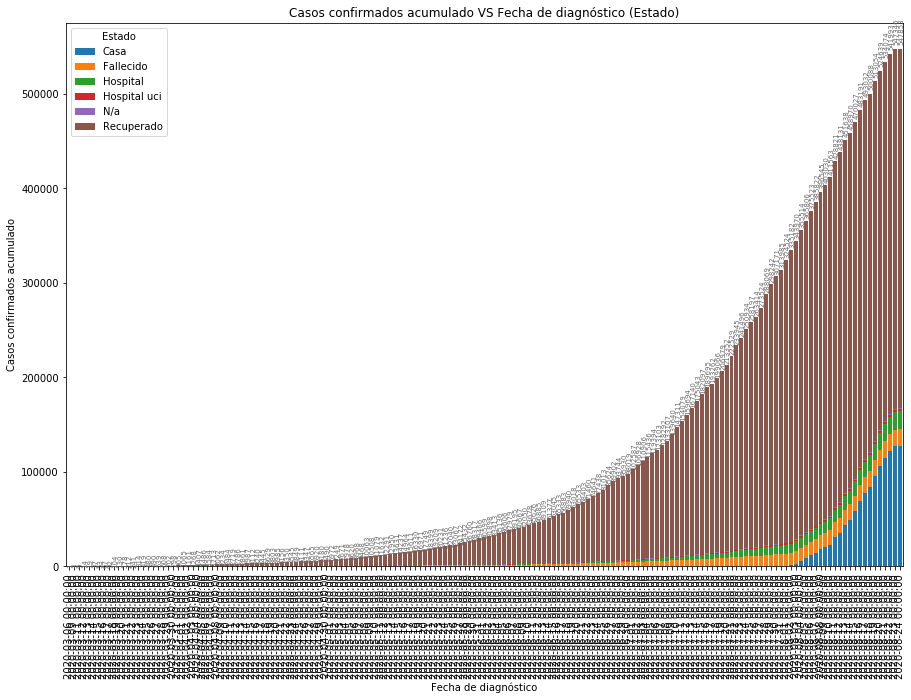

In [23]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulado VS Fecha de diagnóstico (Estado)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Estado'].unique())
numbers(div)

In [24]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Estado                    Casa  Fallecido  Hospital  Hospital uci     N/a  \
Fecha de diagnóstico                                                        
2020-08-24            127751.0    17409.0   19057.0        1890.0  1083.0   
2020-08-23            127270.0    17409.0   19031.0        1890.0  1083.0   
2020-08-22            122228.0    17407.0   18727.0        1885.0  1083.0   
2020-08-21            114852.0    17327.0   18274.0        1880.0  1082.0   
2020-08-20            106194.0    17228.0   17743.0        1870.0  1076.0   
2020-08-19             95867.0    17028.0   16985.0        1837.0  1067.0   
2020-08-18             84316.0    16876.0   16397.0        1830.0  1056.0   
2020-08-17             78045.0    16725.0   15987.0        1829.0  1046.0   
2020-08-16             69441.0    16616.0   15630.0        1826.0  1041.0   
2020-08-15             58388.0    16421.0   15152.0        1825.0  1035.0   
2020-08-14             49339.0    16210.0   14662.0        1812.0  1029.0   
2020-08-13             43864.0    16026.0   14327.0        1801.0  1022.0   
2020-08-12             35577.0    15789.0   13804.0        1782.0  1010.0   
2020-08-11             30865.0    15516.0   13297.0        1759.0  1001.0   
2020-08-10             23043.0    15175.0   12603.0        1702.0   986.0   
2020-08-09             20127.0    14992.0   12245.0        1684.0   971.0   
2020-08-08             17997.0    14794.0   11921.0        1661.0   967.0   
2020-08-07             14407.0    14519.0   11610.0        1625.0   956.0   
2020-08-06             11442.0    14271.0   11265.0        1573.0   941.0   
2020-08-05              8871.0    14014.0   10961.0        1525.0   922.0   
2020-08-04              5978.0    13758.0   10603.0        1477.0   903.0   
2020-08-03              2548.0    13464.0   10272.0        1429.0   888.0   
2020-08-02               875.0    13156.0    9883.0        1388.0   872.0   
2020-08-01               579.0    12816.0    9480.0        1346.0   858.0   
2020-07-31               366.0    12495.0    9027.0        1309.0   838.0   
2020-07-30               319.0    12278.0    8786.0        1286.0   823.0   
2020-07-29               256.0    12002.0    8514.0        1241.0   808.0   
2020-07-28               179.0    11730.0    8193.0        1192.0   788.0   
2020-07-27               148.0    11202.0    7679.0        1133.0   754.0   
2020-07-26               142.0    10893.0    7390.0        1096.0   735.0   
2020-07-25               142.0    10661.0    7202.0        1070.0   724.0   
2020-07-24               122.0    10365.0    6891.0        1032.0   711.0   
2020-07-23                93.0    10076.0    6580.0         994.0   690.0   
2020-07-22                78.0     9713.0    6233.0         954.0   662.0   
2020-07-21                38.0     9276.0    5805.0         900.0   638.0   
2020-07-20                17.0     8934.0    5518.0         849.0   625.0   
2020-07-19                15.0     8667.0    5198.0         816.0   614.0   
2020-07-18                14.0     8392.0    4933.0         790.0   597.0   
2020-07-17                13.0     8155.0    4755.0         760.0   576.0   
2020-07-16                12.0     7983.0    4646.0         746.0   568.0   
2020-07-15                12.0     7702.0    4387.0         709.0   549.0   
2020-07-14                11.0     7409.0    4169.0         674.0   539.0   
2020-07-13                11.0     7125.0    3935.0         645.0   517.0   
2020-07-12                10.0     6859.0    3685.0         612.0   496.0   
2020-07-11                 9.0     6648.0    3529.0         583.0   482.0   
2020-07-10                 8.0     6389.0    3317.0         564.0   455.0   
2020-07-09                 8.0     6170.0    3118.0         535.0   438.0   
2020-07-08                 8.0     5877.0    2868.0         492.0   429.0   
2020-07-07                 7.0     5637.0    2718.0         466.0   420.0   
2020-07-06                 7.0     5425.0    2519.0         437.0   402.0

### - Casos confirmados VS Fecha de diagnóstico (Estado)

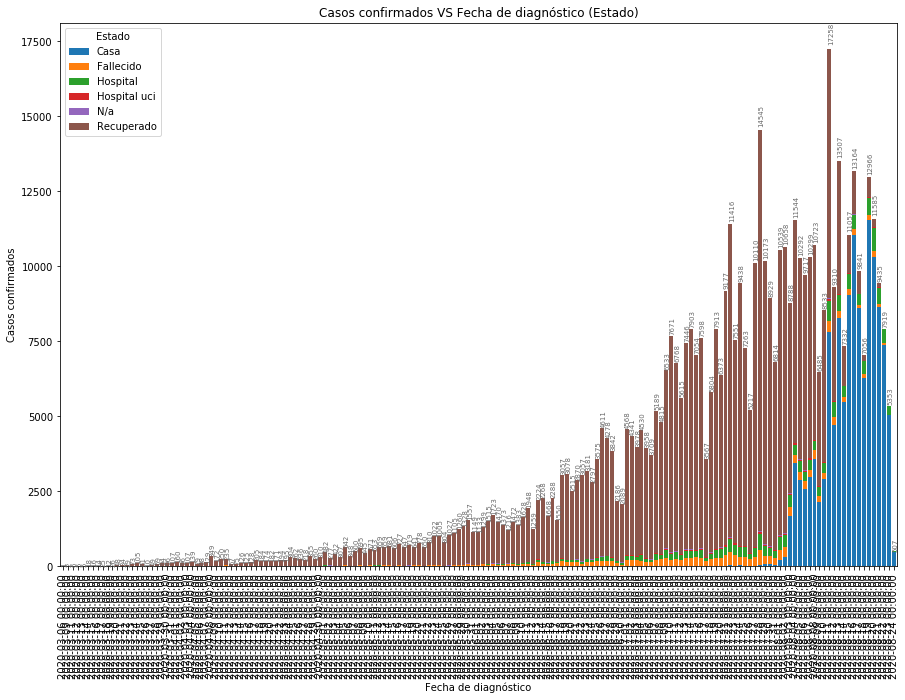

In [25]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Estado)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers(div)

In [26]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).tail(60)[::-1]

Estado                   Casa  Fallecido  Hospital  Hospital uci   N/a  \
Fecha de diagnóstico                                                     
2020-08-24              481.0        0.0      26.0           0.0   0.0   
2020-08-23             5042.0        2.0     304.0           5.0   0.0   
2020-08-22             7376.0       80.0     453.0           5.0   1.0   
2020-08-21             8658.0       99.0     531.0          10.0   6.0   
2020-08-20            10327.0      200.0     758.0          33.0   9.0   
2020-08-19            11551.0      152.0     588.0           7.0  11.0   
2020-08-18             6271.0      151.0     410.0           1.0  10.0   
2020-08-17             8604.0      109.0     357.0           3.0   5.0   
2020-08-16            11053.0      195.0     478.0           1.0   6.0   
2020-08-15             9049.0      211.0     490.0          13.0   6.0   
2020-08-14             5475.0      184.0     335.0          11.0   7.0   
2020-08-13             8287.0      237.0     523.0          19.0  12.0   
2020-08-12             4712.0      273.0     507.0          23.0   9.0   
2020-08-11             7822.0      341.0     694.0          57.0  15.0   
2020-08-10             2916.0      183.0     358.0          18.0  15.0   
2020-08-09             2130.0      198.0     324.0          23.0   4.0   
2020-08-08             3590.0      275.0     311.0          36.0  11.0   
2020-08-07             2965.0      248.0     345.0          52.0  15.0   
2020-08-06             2571.0      257.0     304.0          48.0  19.0   
2020-08-05             2893.0      256.0     358.0          48.0  19.0   
2020-08-04             3430.0      294.0     331.0          48.0  15.0   
2020-08-03             1673.0      308.0     389.0          41.0  16.0   
2020-08-02              296.0      340.0     403.0          42.0  14.0   
2020-08-01              213.0      321.0     453.0          37.0  20.0   
2020-07-31               47.0      217.0     241.0          23.0  15.0   
2020-07-30               63.0      276.0     272.0          45.0  15.0   
2020-07-29               77.0      272.0     321.0          49.0  20.0   
2020-07-28               31.0      528.0     514.0          59.0  34.0   
2020-07-27                6.0      309.0     289.0          37.0  19.0   
2020-07-26                0.0      232.0     188.0          26.0  11.0   
2020-07-25               20.0      296.0     311.0          38.0  13.0   
2020-07-24               29.0      289.0     311.0          38.0  21.0   
2020-07-23               15.0      363.0     347.0          40.0  28.0   
2020-07-22               40.0      437.0     428.0          54.0  24.0   
2020-07-21               21.0      342.0     287.0          51.0  13.0   
2020-07-20                2.0      267.0     320.0          33.0  11.0   
2020-07-19                1.0      275.0     265.0          26.0  17.0   
2020-07-18                1.0      237.0     178.0          30.0  21.0   
2020-07-17                1.0      172.0     109.0          14.0   8.0   
2020-07-16                0.0      281.0     259.0          37.0  19.0   
2020-07-15                1.0      293.0     218.0          35.0  10.0   
2020-07-14                0.0      284.0     234.0          29.0  22.0   
2020-07-13                1.0      266.0     250.0          33.0  21.0   
2020-07-12                1.0      211.0     156.0          29.0  14.0   
2020-07-11                1.0      259.0     212.0          19.0  27.0   
2020-07-10                0.0      219.0     199.0          29.0  17.0   
2020-07-09                0.0      293.0     250.0          43.0   9.0   
2020-07-08                1.0      240.0     150.0          26.0   9.0   
2020-07-07                0.0      212.0     199.0          29.0  18.0   
2020-07-06                2.0      131.0      78.0          14.0  12.0   
2020-07-05                0.0      150.0      97.0          17.0  15.0   
2020-07-04                0.0      193.0     187.0          26.0  19.0   
2020

### - Casos confirmados VS Clasificación de edad (Estado)

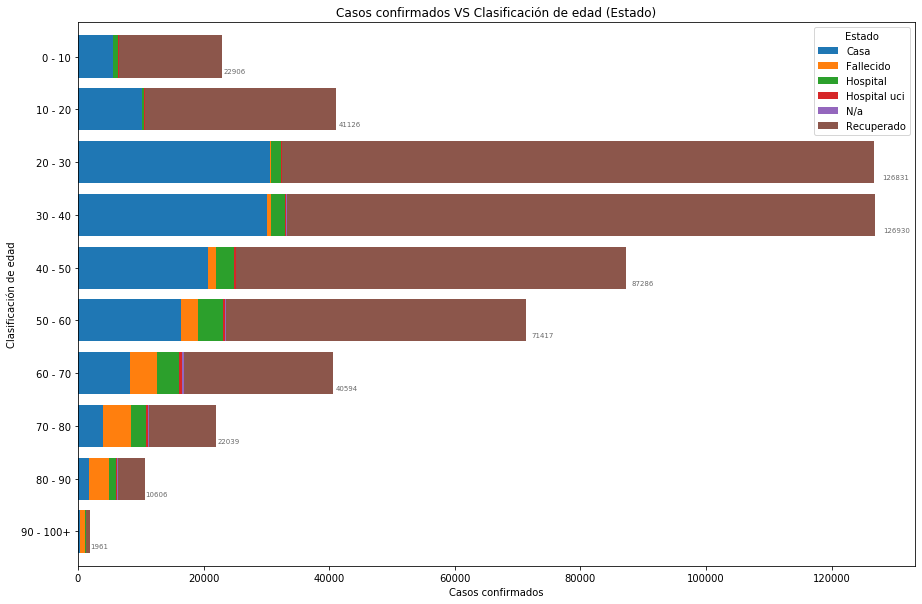

In [27]:
ax = data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Clasificación de edad (Estado)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers_H(div)

In [28]:
data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0)

Estado                  Casa  Fallecido  Hospital  Hospital uci  N/a  \
Clasificación de edad                                                  
0 - 10                  5579         30       833            53   27   
10 - 20                10121         29       415            33   20   
20 - 30                30574        228      1572            77   47   
30 - 40                30135        578      2278           183   39   
40 - 50                20730       1299      2781           283   87   
50 - 60                16435       2683      3900           471  133   
60 - 70                 8261       4264      3623           445  225   
70 - 80                 3930       4463      2404           278  257   
80 - 90                 1695       3289      1154            74  216   
90 - 100+                300        749       183             7   55   

Estado                 Recuperado  
Clasificación de edad              
0 - 10                      16384  
10 - 20                     30508  
20 - 30                     94333  
30 - 40                     93717  
40 - 50                     62106  
50 - 60                     47795  
60 - 70                     23776  
70 - 80                     10707  
80 - 90                      4178  
90 - 100+                     667

### - Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)

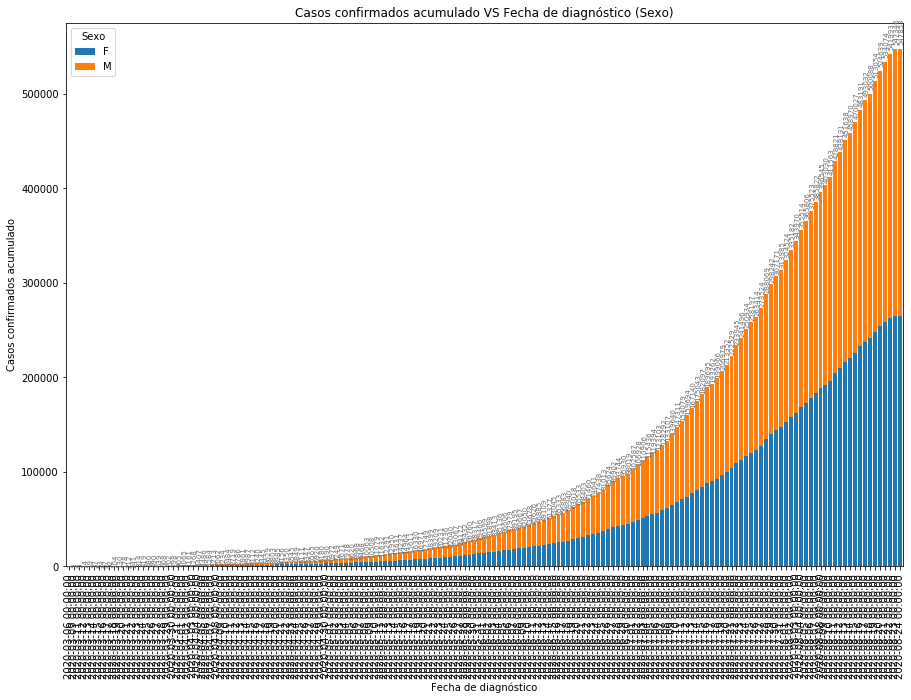

In [29]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Sexo'].unique())
numbers(div)

In [30]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Sexo                         F         M
Fecha de diagnóstico                    
2020-08-24            265375.0  282478.0
2020-08-23            265118.0  282228.0
2020-08-22            262325.0  279668.0
2020-08-21            258586.0  275488.0
2020-08-20            253823.0  270816.0
2020-08-19            247976.0  265078.0
2020-08-18            241238.0  258850.0
2020-08-17            237815.0  255217.0
2020-08-16            232608.0  250583.0
2020-08-15            225722.0  244305.0
2020-08-14            220070.0  238900.0
2020-08-13            216317.0  235321.0
2020-08-12            209550.0  228581.0
2020-08-11            204942.0  223879.0
2020-08-10            195992.0  215571.0
2020-08-09            191712.0  211318.0
2020-08-08            188366.0  208179.0
2020-08-07            183139.0  202683.0
2020-08-06            178105.0  197418.0
2020-08-05            173297.0  192509.0
2020-08-04            168131.0  187383.0
2020-08-03            162348.0  181622.0
2020-08-02            158091.0  177091.0
2020-08-01            152638.0  171886.0
2020-07-31            147535.0  166450.0
2020-07-30            144109.0  163062.0
2020-07-29            139777.0  158465.0
2020-07-28            134723.0  153346.0
2020-07-27            127628.0  145896.0
2020-07-26            122781.0  140633.0
2020-07-25            120391.0  137806.0
2020-07-24            116716.0  134218.0
2020-07-23            112354.0  129142.0
2020-07-22            108785.0  125160.0
2020-07-21            103622.0  118907.0
2020-07-20             99322.0  114030.0
2020-07-19             96346.0  110633.0
2020-07-18             92556.0  106510.0
2020-07-17             89775.0  103487.0
2020-07-16             88018.0  101677.0
2020-07-15             84288.0   97809.0
2020-07-14             80942.0   94101.0
2020-07-13             77346.0   89794.0
2020-07-12             73777.0   85917.0
2020-07-11             71103.0   82976.0
2020-07-10             67889.0   79422.0
2020-07-09             64385.0   75255.0
2020-07-08             61420.0   71687.0
2020-07-07             59110.0   69182.0
2020-07-06             56701.0   66402.0
2020-07-05             54948.0   64446.0
2020-07-04             53114.0   62322.0
2020-07-03             51085.0   59821.0
2020-07-02             49229.0   57699.0
2020-07-01             47200.0   55387.0
2020-06-30             45125.0   52894.0
2020-06-29             44152.0   51778.0
2020-06-28             43152.0   50592.0
2020-06-27             41312.0   48590.0
2020-06-26             39315.0   46309.0

### - Casos confirmados VS Fecha de diagnóstico (Sexo)

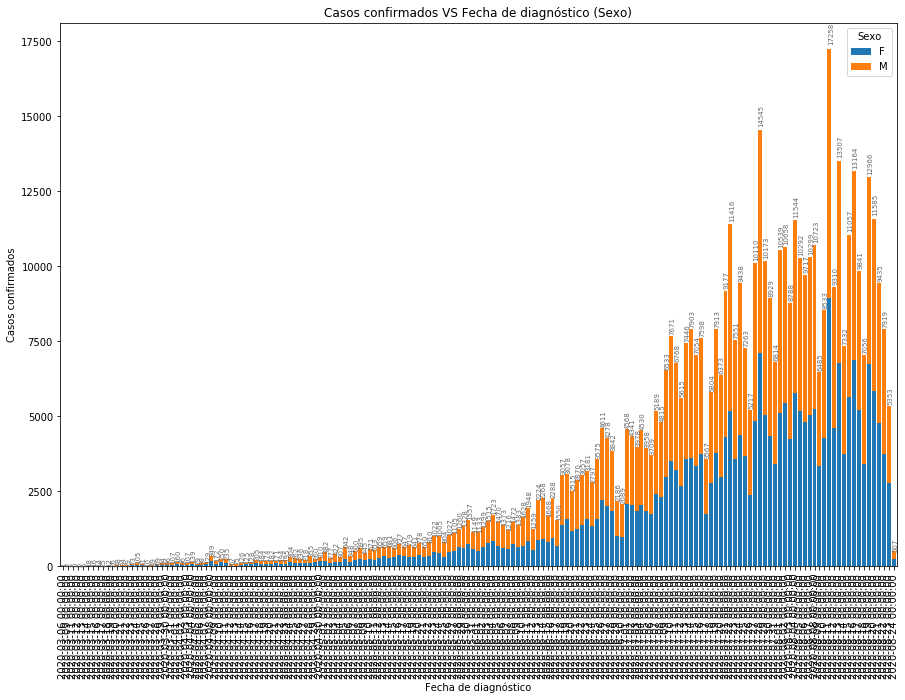

In [31]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Sexo)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers(div)

In [32]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).tail(60)[::-1]

Sexo                       F       M
Fecha de diagnóstico                
2020-08-24             257.0   250.0
2020-08-23            2793.0  2560.0
2020-08-22            3739.0  4180.0
2020-08-21            4763.0  4672.0
2020-08-20            5847.0  5738.0
2020-08-19            6738.0  6228.0
2020-08-18            3423.0  3633.0
2020-08-17            5207.0  4634.0
2020-08-16            6886.0  6278.0
2020-08-15            5652.0  5405.0
2020-08-14            3753.0  3579.0
2020-08-13            6767.0  6740.0
2020-08-12            4608.0  4702.0
2020-08-11            8950.0  8308.0
2020-08-10            4280.0  4253.0
2020-08-09            3346.0  3139.0
2020-08-08            5227.0  5496.0
2020-08-07            5034.0  5265.0
2020-08-06            4808.0  4909.0
2020-08-05            5166.0  5126.0
2020-08-04            5783.0  5761.0
2020-08-03            4257.0  4531.0
2020-08-02            5453.0  5205.0
2020-08-01            5103.0  5436.0
2020-07-31            3426.0  3388.0
2020-07-30            4332.0  4597.0
2020-07-29            5054.0  5119.0
2020-07-28            7095.0  7450.0
2020-07-27            4847.0  5263.0
2020-07-26            2390.0  2827.0
2020-07-25            3675.0  3588.0
2020-07-24            4362.0  5076.0
2020-07-23            3569.0  3982.0
2020-07-22            5163.0  6253.0
2020-07-21            4300.0  4877.0
2020-07-20            2976.0  3397.0
2020-07-19            3790.0  4123.0
2020-07-18            2781.0  3023.0
2020-07-17            1757.0  1810.0
2020-07-16            3730.0  3868.0
2020-07-15            3346.0  3708.0
2020-07-14            3596.0  4307.0
2020-07-13            3569.0  3877.0
2020-07-12            2674.0  2941.0
2020-07-11            3214.0  3554.0
2020-07-10            3504.0  4167.0
2020-07-09            2965.0  3568.0
2020-07-08            2310.0  2505.0
2020-07-07            2409.0  2780.0
2020-07-06            1753.0  1956.0
2020-07-05            1834.0  2124.0
2020-07-04            2029.0  2501.0
2020-07-03            1856.0  2122.0
2020-07-02            2029.0  2312.0
2020-07-01            2075.0  2493.0
2020-06-30             973.0  1116.0
2020-06-29            1000.0  1186.0
2020-06-28            1840.0  2002.0
2020-06-27            1997.0  2281.0
2020-06-26            2194.0  2417.0

### - Casos confirmados VS Clasificación de edad (Sexo)

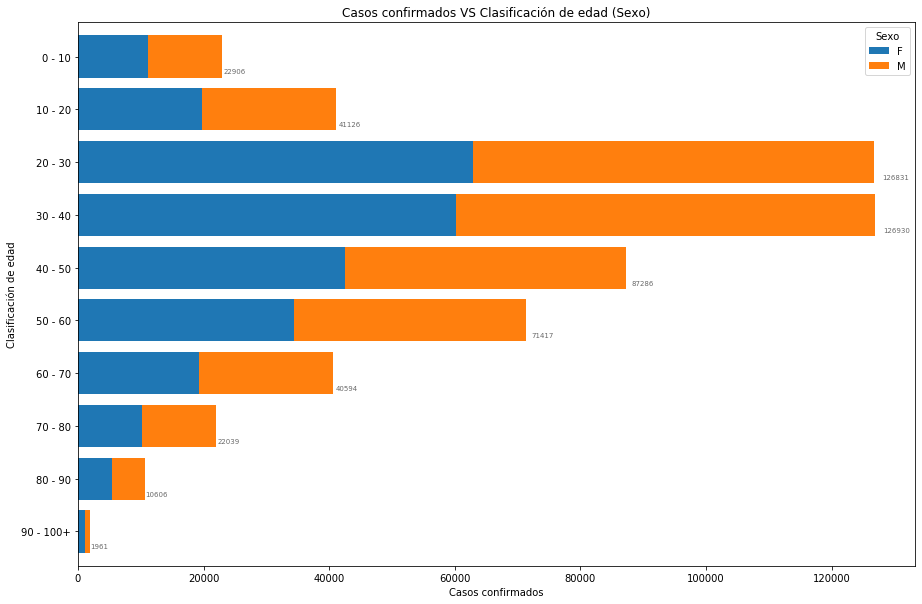

In [33]:
ax = data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Clasificación de edad (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [34]:
data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0)

Sexo                       F      M
Clasificación de edad              
0 - 10                 11190  11716
10 - 20                19711  21415
20 - 30                62939  63892
30 - 40                60269  66661
40 - 50                42591  44695
50 - 60                34474  36943
60 - 70                19223  21371
70 - 80                10277  11762
80 - 90                 5399   5207
90 - 100+               1120    841

### - Casos confirmados VS Estado (Sexo)

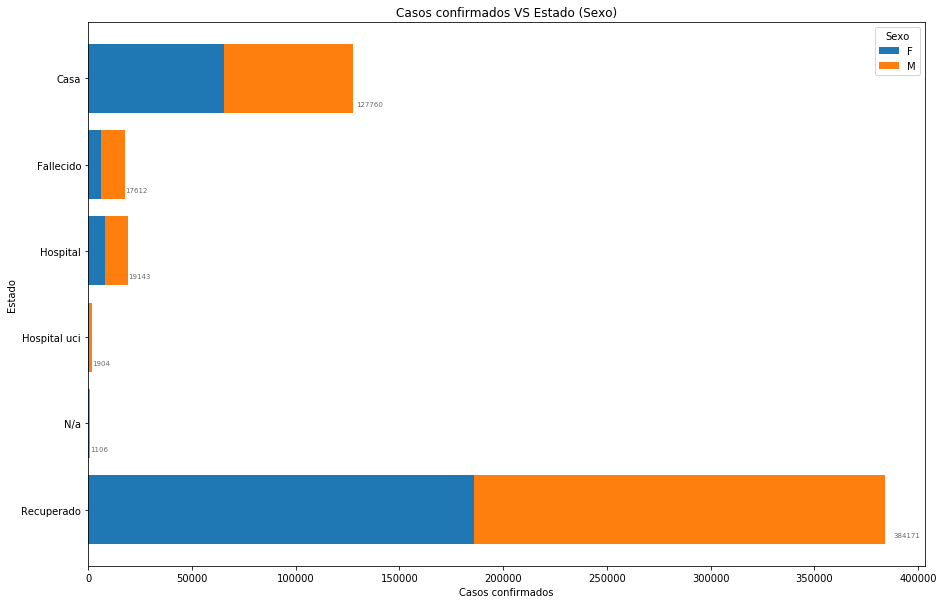

In [35]:
ax = data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Estado (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [36]:
data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0)

Sexo               F       M
Estado                      
Casa           65393   62367
Fallecido       6319   11293
Hospital        8182   10961
Hospital uci     665    1239
N/a              477     629
Recuperado    186157  198014

### - Casos confirmados VS Tipo de contagio (Sexo)

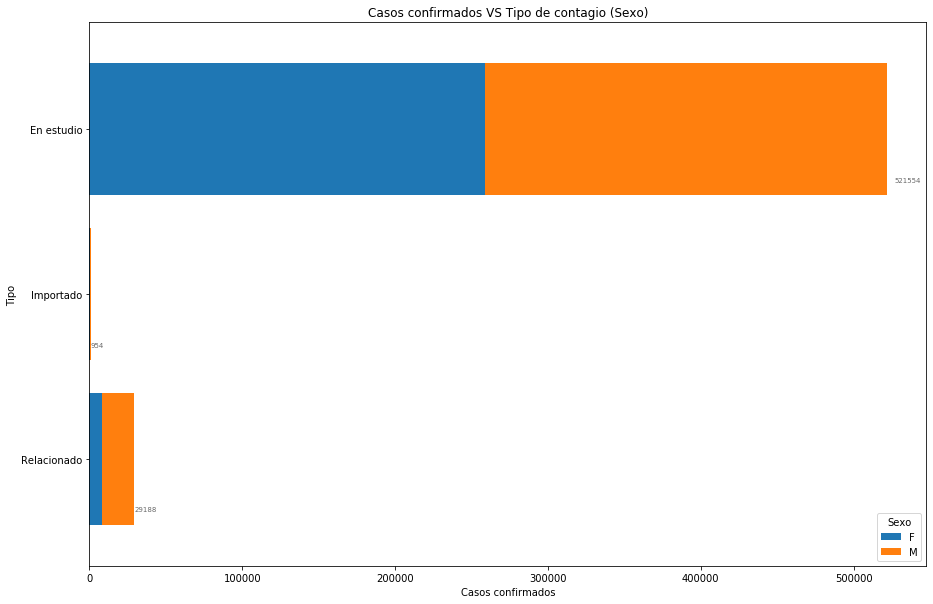

In [37]:
ax = data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Tipo de contagio (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [38]:
data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0)

Sexo              F       M
Tipo                       
En estudio   258759  262795
Importado       447     507
Relacionado    7987   21201

### - Casos confirmados acumulado VS Fecha de diagnóstico (Clasificación de edad)

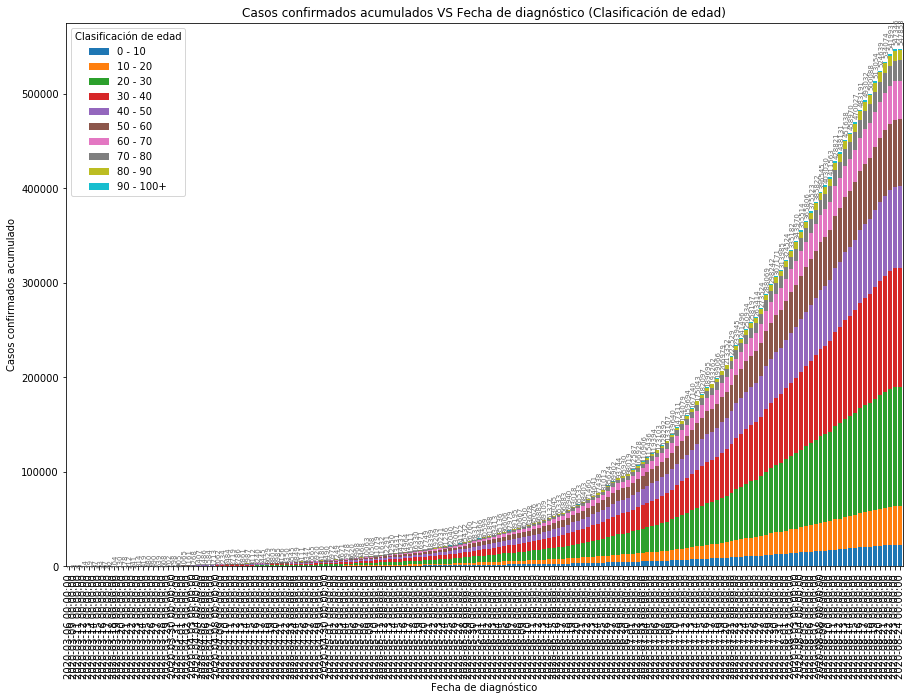

In [39]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulados VS Fecha de diagnóstico (Clasificación de edad)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [40]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-08-24              22771    40850   125920   126003    86721    70946   
2020-08-23              22762    40815   125793   125869    86641    70886   
2020-08-22              22525    40376   124533   124643    85818    70174   
2020-08-21              22226    39764   122702   122764    84642    69172   
2020-08-20              21843    39075   120476   120606    83159    67936   
2020-08-19              21380    38250   117929   118023    81340    66382   
2020-08-18              20764    37292   115017   115121    79229    64753   
2020-08-17              20520    36809   113465   113551    78106    63782   
2020-08-16              20009    36060   111282   111489    76537    62465   
2020-08-15              19397    34935   108352   108619    74441    60741   
2020-08-14              18901    34112   105830   106171    72703    59253   
2020-08-13              18650    33586   104156   104542    71522    58225   
2020-08-12              18033    32531   101114   101489    69366    56441   
2020-08-11              17694    31905    99074    99354    67886    55202   
2020-08-10              16907    30672    95011    95355    65073    52976   
2020-08-09              16581    29998    93087    93372    63735    51875   
2020-08-08              16341    29578    91590    91964    62662    51003   
2020-08-07              15926    28799    89169    89344    60977    49597   
2020-08-06              15512    28030    86813    86916    59341    48263   
2020-08-05              15065    27288    84655    84699    57788    46998   
2020-08-04              14639    26572    82294    82320    56122    45641   
2020-08-03              14152    25760    79641    79626    54226    44062   
2020-08-02              13828    25153    77651    77579    52887    42849   
2020-08-01              13386    24433    75243    75195    51085    41353   
2020-07-31              12974    23579    72691    72692    49469    40019   
2020-07-30              12701    23124    71169    71064    48305    39185   
2020-07-29              12358    22413    68999    68941    46990    38021   
2020-07-28              11978    21672    66583    66475    45311    36784   
2020-07-27              11349    20542    63264    63194    42998    34860   
2020-07-26              10963    19823    60884    60820    41337    33659   
2020-07-25              10752    19498    59696    59597    40528    32979   
2020-07-24              10468    19014    58062    57898    39364    31996   
2020-07-23              10147    18293    55858    55610    37889    30762   
2020-07-22               9870    17777    54175    53863    36688    29772   
2020-07-21               9464    16931    51453    51273    34903    28228   
2020-07-20               9103    16305    49289    49092    33423    27077   
2020-07-19               8825    15845    47934    47632    32355    26248   
2020-07-18               8512    15185    46100    45776    31045    25266   
2020-07-17               8290    14843    44806    44360    30088    24514   
2020-07-16               8167    14624    44004    43499    29541    24060   
2020-07-15               7825    14119    42298    41696    28296    23043   
2020-07-14               7532    13585    40701    40088    27171    22114   
2020-07-13               7236    13003    38833    38210    25895    21138   
2020-07-12               6981    12514    37051    36495    24681    20150   
2020-07-11               6740    12089    35740    35222    23767    19408   
2020-07-10               6489    11641    34109    33591    22682    18552   
2020-07-09               6204    11091    32254    31708    21524    17564   
2020-07-08               5984    10663    30700    30138    20484    16751   
2020-07-07               5794    10337    29607    28995    19714    16127   
2020-07-06            

### - Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)

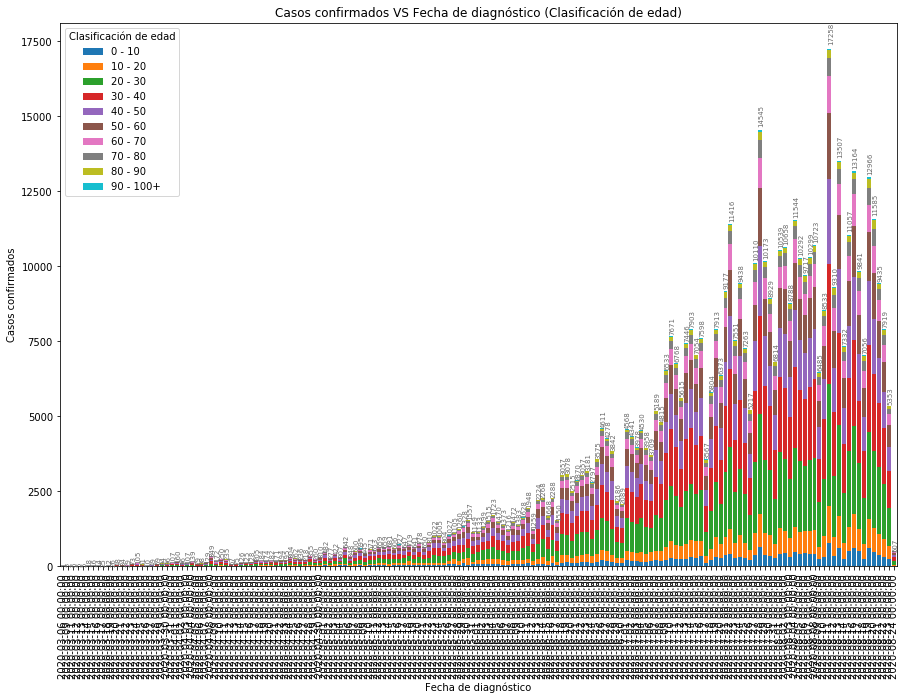

In [41]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [42]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-08-24                  9       35      127      134       80       60   
2020-08-23                237      439     1260     1226      823      712   
2020-08-22                299      612     1831     1879     1176     1002   
2020-08-21                383      689     2226     2158     1483     1236   
2020-08-20                463      825     2547     2583     1819     1554   
2020-08-19                616      958     2912     2902     2111     1629   
2020-08-18                244      483     1552     1570     1123      971   
2020-08-17                511      749     2183     2062     1569     1317   
2020-08-16                612     1125     2930     2870     2096     1724   
2020-08-15                496      823     2522     2448     1738     1488   
2020-08-14                251      526     1674     1629     1181     1028   
2020-08-13                617     1055     3042     3053     2156     1784   
2020-08-12                339      626     2040     2135     1480     1239   
2020-08-11                787     1233     4063     3999     2813     2226   
2020-08-10                326      674     1924     1983     1338     1101   
2020-08-09                240      420     1497     1408     1073      872   
2020-08-08                415      779     2421     2620     1685     1406   
2020-08-07                414      769     2356     2428     1636     1334   
2020-08-06                447      742     2158     2217     1553     1265   
2020-08-05                426      716     2361     2379     1666     1357   
2020-08-04                487      812     2653     2694     1896     1579   
2020-08-03                324      607     1990     2047     1339     1213   
2020-08-02                442      720     2408     2384     1802     1496   
2020-08-01                412      854     2552     2503     1616     1334   
2020-07-31                273      455     1522     1628     1164      834   
2020-07-30                343      711     2170     2123     1315     1164   
2020-07-29                380      741     2416     2466     1679     1237   
2020-07-28                629     1130     3319     3281     2313     1924   
2020-07-27                386      719     2380     2374     1661     1201   
2020-07-26                211      325     1188     1223      809      680   
2020-07-25                284      484     1634     1699     1164      983   
2020-07-24                321      721     2204     2288     1475     1234   
2020-07-23                277      516     1683     1747     1201      990   
2020-07-22                406      846     2722     2590     1785     1544   
2020-07-21                361      626     2164     2181     1480     1151   
2020-07-20                278      460     1355     1460     1068      829   
2020-07-19                313      660     1834     1856     1310      982   
2020-07-18                222      342     1294     1416      957      752   
2020-07-17                123      219      802      861      547      454   
2020-07-16                342      505     1706     1803     1245     1017   
2020-07-15                293      534     1597     1608     1125      929   
2020-07-14                296      582     1868     1878     1276      976   
2020-07-13                255      489     1782     1715     1214      988   
2020-07-12                241      425     1311     1273      914      742   
2020-07-11                251      448     1631     1631     1085      856   
2020-07-10                285      550     1855     1883     1158      988   
2020-07-09                220      428     1554     1570     1040      813   
2020-07-08                190      326     1093     1143      770      624   
2020-07-07                200      297     1228     1268      889      643   
2020-07-06            

### - Casos confirmados VS Estado (Clasificación de edad)

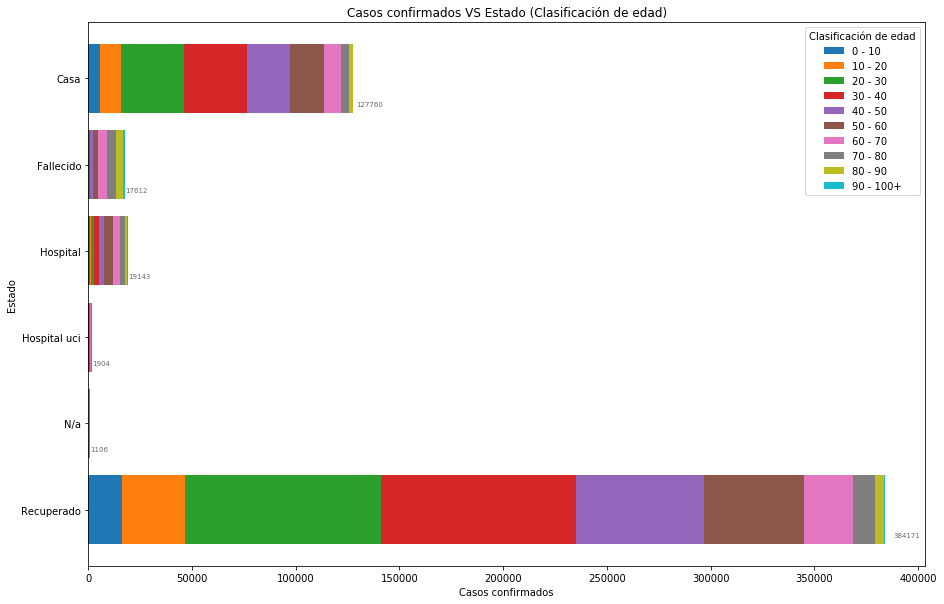

In [43]:
ax = data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Estado (Clasificación de edad)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [44]:
data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Estado                                                                       
Casa                     5579    10121    30574    30135    20730    16435   
Fallecido                  30       29      228      578     1299     2683   
Hospital                  833      415     1572     2278     2781     3900   
Hospital uci               53       33       77      183      283      471   
N/a                        27       20       47       39       87      133   
Recuperado              16384    30508    94333    93717    62106    47795   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Estado                                                       
Casa                      8261     3930     1695        300  
Fallecido                 4264     4463     3289        749  
Hospital                  3623     2404     1154        183  
Hospital uci               445      278       74          7  
N/a                        225      257      216         55  
Recuperado               23776    10707     4178        667

### - Casos confirmados VS Tipo de contagio (Clasificación de edad)

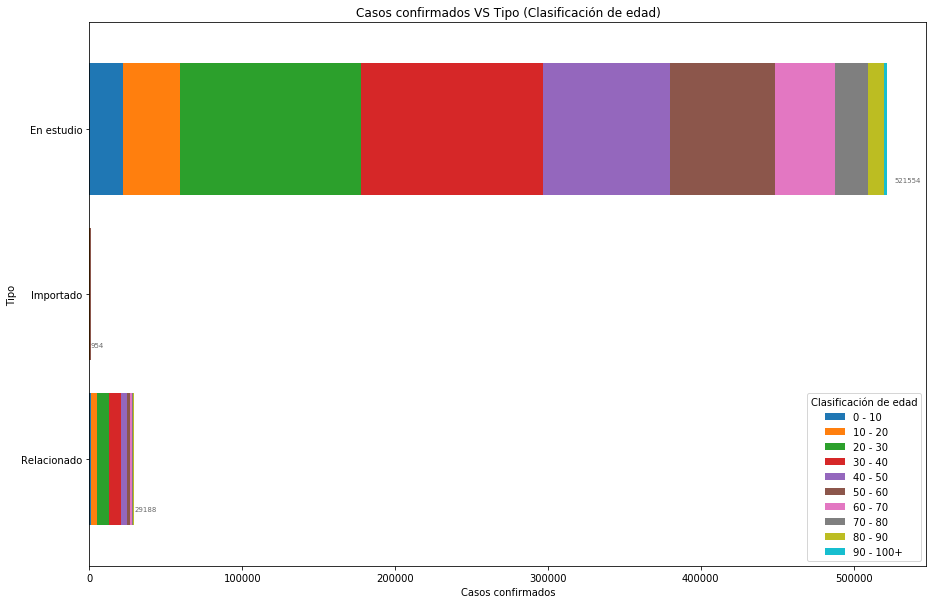

In [45]:
ax = data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Tipo (Clasificación de edad)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [46]:
data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Tipo                                                                         
En estudio              21916    37375   118321   119129    83399    68728   
Importado                   5       37      240      222      167      144   
Relacionado               985     3714     8270     7579     3720     2545   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Tipo                                                         
En estudio               39183    21415    10222       1866  
Importado                   94       35        9          1  
Relacionado               1317      589      375         94

## #StayHome 🏠 #QuédateEnCasa
## #WearMask 😷 #UsaMascarilla 

### Creado con ❤️ por <a href='https://github.com/jlcadavid'>@jlcadavid</a>